In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path

import hardware

In [2]:
def mjd_to_hours(mjd):
    seconds_per_day = 86400  # 24 hours * 60 minutes * 60 seconds
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd[0]) * 24
    
    return hours_since_start


In [8]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.99 # start with full 
print(config)

{'initial': 238.58010000000002, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


## First Model (Cold Night 1) 7/1/24

In [ ]:
ryan_pvt = pd.read_csv('ColdNight1_PowerVsTime.csv',delimiter=',', header= None)

ryan_pvt = ryan_pvt.drop(11, axis =0)
ryan_pvt = ryan_pvt.drop(12, axis =0)
ryan_pvt = ryan_pvt.drop(14, axis =0)
ryan_pvt = ryan_pvt.drop(15, axis =0) ## removes extra rows at the bottom


ryan_pvt= ryan_pvt.T ## flips
ryan_pvt.columns = ryan_pvt.iloc[0] ## sets col
ryan_pvt = ryan_pvt.drop(0)

ryan_pvt['Summed_all'] = ryan_pvt['PMU Q_SUM'].astype(float)+ryan_pvt['PFPS_Q_SUM'].astype(float)+ryan_pvt['PDU_Q_SUM'].astype(float)+ryan_pvt['DCB_Q_SUM'].astype(float)+ryan_pvt['Spectrometer_Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 1 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 2 Q_SUM'].astype(float)+ryan_pvt['Pre-Amp 3 Q_SUM'].astype(float) +ryan_pvt['Pre-Amp 4 Q_SUM'].astype(float)+ryan_pvt['Radio_SUM'].astype(float)+ryan_pvt['POHTR_BATT'].astype(float)

ryan_pvt = ryan_pvt[0:2362] ## removes min max)
ryan_pvt['Nodes/Times'].astype(float)
#print(ryan_pvt)

In [ ]:
sol_pvt = pd.read_csv('solpow_v_time.csv',delimiter=',')
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['time'])
sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(ryan_pvt['Nodes/Times'])]

# interp1d lunar power data to the time points of batt_hrs
interp_func = interp1d(sol_pvt['sol_hrs'], sol_pvt['solar_pow'], fill_value='extrapolate')
lunar_pow_interp = interp_func(pd.to_numeric(ryan_pvt['Nodes/Times']))
print(len(lunar_pow_interp))


In [ ]:
################   NIGHT CYCLE  ##################################
ryan_pvt = ryan_pvt[ryan_pvt['Nodes/Times'] > 180]

In [ ]:
colors = ['b','g','k']
T = 0 ## we need this from Ryan
plt.figure()
B = hardware.Battery(config, verbose=False)
B.set_temperature(T)
energy = 0
deltaT_list= []
soc_values = []
power_values = []
time_list = []
solar_applied = False
solar_index = 0 
sol_cont = []
cond_heater = 0 ## 3.27  if heater
for i in range(len(ryan_pvt['Nodes/Times']) - 1):
    deltaT =  3600*(ryan_pvt['Nodes/Times'].iloc[i+1] -ryan_pvt['Nodes/Times'].iloc[i])
    deltaT_list.append(deltaT)
    P =ryan_pvt['Summed_all'].iloc[i] + cond_heater ## added from heater per Ryan's suggestion
    
    if not solar_applied:
        sol_cont.append(0)
        power_values.append(P)
        B.apply_power(-P,deltaT) # discharge at 1W
        B.apply_age(deltaT)
        energy += deltaT*P
        #energy_l.append(energy)
        soc_values.append(B.SOC())
   
    if ryan_pvt['Nodes/Times'].iloc[i] >= 516.0 and not solar_applied:
       while solar_index <= (len(ryan_pvt['Nodes/Times'])-i): 
           ### discharging
           deltaT =  3600*(ryan_pvt['Nodes/Times'].iloc[solar_index+1] -ryan_pvt['Nodes/Times'].iloc[solar_index])
           P =ryan_pvt['Summed_all'].iloc[solar_index+i] + cond_heater ## added from heater per Ryan's suggestion
           B.apply_power(-P,deltaT) 
           power_values.append(P)
           
           
           ### charging
           P_add = sol_pvt['solar_pow'].iloc[solar_index]
           B.apply_power(P_add, deltaT)
           solar_index += 1
           energy += deltaT*(P_add-P)
           sol_cont.append(P_add)
           soc_values.append(B.SOC())
               #energy_l.append(energy)
           if len(soc_values) > len(ryan_pvt['Nodes/Times']) - 1:
                   break
           solar_applied = True

dict_val = {'Time':ryan_pvt['Nodes/Times'], 'SOC':soc_values,'Power_hardware':power_values,'Power_sol_pan':sol_cont}      
df = pd.DataFrame.from_dict(dict_val)
pd.DataFrame.to_csv(df,'t_soc_pow'+str(cond_heater)+'.csv')
print(np.min(soc_values))                   
print(df)
plt.subplot(3, 1, 1)
plt.title('With '+str(cond_heater)+'W Heater')
plt.plot(ryan_pvt['Nodes/Times'], soc_values, color ='blue' ,label=T)
plt.ylim(-0.1,1.1)
#plt.xlim(200,320)
plt.ylabel('SOC')
plt.subplot(3, 1, 2)
plt.plot(ryan_pvt['Nodes/Times'],power_values, color = 'orange' ,label=T )
plt.ylabel('P (watts)')
#plt.xlim(200,320)
 
plt.subplot(3, 1, 3)
plt.plot(ryan_pvt['Nodes/Times'], sol_cont, color = 'red',label='solar panel')
plt.ylabel('P (watts)')
plt.legend()
plt.xlabel('Time (hours)')
plt.show() 




## Compare with new model (Night1) 7/22/24

0    Time, Hours LuSEE Q Total_SUM POHTR_BATT Eclipse Heater Power, W 3.11  \
1            0.0              28.0        0.0                     NaN  NaN   
2       0.277778              28.0        0.0                     NaN  NaN   
3       0.555556              28.0        0.0                     NaN  NaN   
4       0.833333              28.0        0.0                     NaN  NaN   
5       1.111111              28.0        0.0                     NaN  NaN   
...          ...               ...        ...                     ...  ...   
2358  654.722222             22.74        0.0                     NaN  NaN   
2359       655.0             22.74        0.0                     NaN  NaN   
2360  655.277778             22.74        0.0                     NaN  NaN   
2361  655.555556             22.74        0.0                     NaN  NaN   
2362  655.716667              28.0        0.0                     NaN  NaN   

0    PreHeating Heater Power, W 6.28  tot_sum  
1              

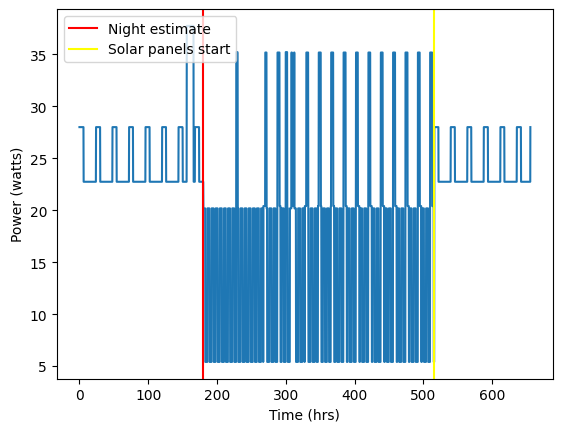

In [9]:
night1_coldpow = pd.read_csv('Night1_Cold Power_07192024.csv',delimiter=',', header= None)
eclipse_heat_pow = 3.11 # watts
preheating_pow = 6.28 # watts

night1_coldpow = night1_coldpow.T ## flips
night1_coldpow.columns = night1_coldpow.iloc[0] ## sets col
night1_coldpow = night1_coldpow.drop(0)
night1_coldpow = night1_coldpow[0:2362]
#
night1_coldpow['tot_sum'] = night1_coldpow['LuSEE Q Total_SUM'].astype(float) + night1_coldpow['POHTR_BATT'].astype(float) 
print(night1_coldpow)
plt.plot(night1_coldpow['Time, Hours'], night1_coldpow['tot_sum'])
plt.xlabel('Time (hrs)')
plt.ylabel('Power (watts)')
plt.axvline(x = 180, color = 'red',label='Night estimate')
plt.axvline(x = 516, color = 'yellow',label='Solar panels start')
plt.legend()

In [10]:
sol_pvt = pd.read_csv('solpow_v_time.csv',delimiter=',') ## loading in solar power data
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['time'])
sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(night1_coldpow['Time, Hours'])]

# interp1d lunar power data to the time points of batt_hrs
interp_func = interp1d(sol_pvt['sol_hrs'], sol_pvt['solar_pow'], fill_value='extrapolate')
lunar_pow_interp = interp_func(pd.to_numeric(night1_coldpow['Time, Hours']))
print(len(lunar_pow_interp))

2362


In [11]:
################   NIGHT CYCLE  ##################################
night1_coldpow = night1_coldpow[night1_coldpow['Time, Hours'] > 180]

0.2497262584939497
            Time       SOC  Power_hardware  Power_sol_pan
650   180.277778  0.995576           20.18       0.000000
651   180.555556  0.994875           20.18       0.000000
652   180.833333  0.994173           20.18       0.000000
653   181.111111  0.993470           20.18       0.000000
654   181.388889  0.992768           20.18       0.000000
...          ...       ...             ...            ...
2358  654.722222  1.000000           22.74     123.499062
2359       655.0  1.000000           22.74     123.451783
2360  655.277778  1.000000           22.74     123.403833
2361  655.555556  1.000000           22.74     123.355211
2362  655.716667  1.000000           22.74     123.305917

[1713 rows x 4 columns]


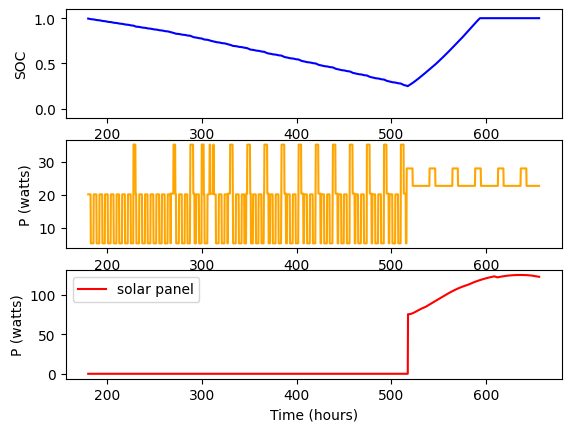

In [13]:
colors = ['b','g','k']
T = 0 ## we need this from Ryan
plt.figure()
B = hardware.Battery(config, verbose=False)
B.set_temperature(T)
energy = 0
deltaT_list= []
soc_values = []
power_values = []
time_list = []
solar_applied = False
solar_index = 0 
sol_cont = []
cond_heater = 0 ## 3.27  if heater
for i in range(len(night1_coldpow['Time, Hours']) - 1):
    deltaT =  3600*(night1_coldpow['Time, Hours'].iloc[i+1] -night1_coldpow['Time, Hours'].iloc[i])
    deltaT_list.append(deltaT)
    P = night1_coldpow['tot_sum'].iloc[i] 
    if not solar_applied:
        sol_cont.append(0)
        power_values.append(P)
        B.apply_power(-P,deltaT) # discharge at 1W
        B.apply_age(deltaT)
        energy += deltaT*P
        #energy_l.append(energy)
        soc_values.append(B.SOC())
   
    if night1_coldpow['Time, Hours'].iloc[i] >= 516.0 and not solar_applied:
       while solar_index <= (len(night1_coldpow['Time, Hours'])-i): 
           ### discharging
           deltaT =  3600*(night1_coldpow['Time, Hours'].iloc[solar_index+1] - night1_coldpow['Time, Hours'].iloc[solar_index])
           P =night1_coldpow['tot_sum'].iloc[solar_index+i] 
           B.apply_power(-P,deltaT) 
           power_values.append(P)

           ### charging
           P_add = sol_pvt['solar_pow'].iloc[solar_index]
           B.apply_power(P_add, deltaT)
           solar_index += 1
           energy += deltaT*(P_add-P)
           sol_cont.append(P_add)
           soc_values.append(B.SOC())
               #energy_l.append(energy)
           if len(soc_values) > len(night1_coldpow['Time, Hours']) - 1:
                   break
           solar_applied = True

dict_val = {'Time':night1_coldpow['Time, Hours'], 'SOC':soc_values,'Power_hardware':power_values,'Power_sol_pan':sol_cont}      
df = pd.DataFrame.from_dict(dict_val)
pd.DataFrame.to_csv(df,'Night1_t_soc_pow.csv')
print(np.min(soc_values))                   
print(df)
plt.subplot(3, 1, 1)
#plt.title('')
plt.plot(night1_coldpow['Time, Hours'], soc_values, color ='blue' ,label=T)
plt.ylim(-0.1,1.1)
#plt.xlim(200,320)
plt.ylabel('SOC')
plt.subplot(3, 1, 2)
plt.plot(night1_coldpow['Time, Hours'],power_values, color = 'orange' ,label=T )
plt.ylabel('P (watts)')
#plt.xlim(200,320)
 
plt.subplot(3, 1, 3)
plt.plot(night1_coldpow['Time, Hours'], sol_cont, color = 'red',label='solar panel')
plt.ylabel('P (watts)')
plt.legend()
plt.xlabel('Time (hours)')
plt.show() 